# LAB 5-BIS: Graph Representation Learnin with Node2Vec for Recommender System - Movielens case study

Giorgio Lazzarinetti - My Contacts
For any questions or doubts you can find my contacts here:

giorgio.lazzarinetti@unimib.it g.lazzarinetti@campus.unimib.it


## Notebook Outline

- **Introduction to Movie Graph**
- **LAB CHALLENGE: Representation Learning for Movie on Graph**

In [ ]:
# NECESSARY IMPIRT
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.manifold import TSNE

## MOVIES GRAPH

In the following er are going to see how we can model recommender system with graph. in particular we are going to build a network of movies, by considering movies connected if they have been liked by the same user.

Since we want to keep models simple and small we are going to use a smaller dataset with respect to the 100k dataset. The used dataset is the ml-latest-small. You can download it here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip. After that to use it, save it in your colab directory.

In [ ]:
# Download and extract dataset
urlretrieve(
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip", "movielens.zip"
)
ZipFile("movielens.zip", "r").extractall()

### Movies and Ratings

let's read the movies.csv file and the ratings.csv file. In the following we are going to focus mainly on movies and not on users. We are not going to use direct movies features, the only fact we are going to rely on is the preferences expressed by users through ratings.

In [ ]:
# Load movies to a DataFrame
movies = pd.read_csv("ml-latest-small/movies.csv")
movies.head(5)
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame
ratings = pd.read_csv("ml-latest-small/ratings.csv")
ratings.head(5)
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

Movies data shape: (9742, 3)
Ratings data shape: (100836, 4)


In [ ]:
movies.head(5)

,movieId,title,genres
0,movie_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,movie_2,Jumanji (1995),Adventure|Children|Fantasy
2,movie_3,Grumpier Old Men (1995),Comedy|Romance
3,movie_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,movie_5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head(5)

,userId,movieId,rating,timestamp
0,1,movie_1,4.0,964982703
1,1,movie_3,4.0,964981247
2,1,movie_6,4.0,964982224
3,1,movie_47,5.0,964983815
4,1,movie_50,5.0,964982931


In [ ]:
# these function will be used to plot the movies and see the results
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

### Construct the movies graph

We create an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. The weight of the edge will be based on the pointwise mutual information between the two movies, which is computed as: $log(xy) - log(x) - log(y) + log(D)$, where:

- xy is how many users rated both movie x and movie y with >= min_rating.
- x is how many users rated movie x >= min_rating.
- y is how many users rated movie y >= min_rating.
- D total number of movie ratings >= min_rating.

In [ ]:
# Compute movie rating frequencies
min_rating = 5
#dictionary that counts how many times a pair of movies have been evaluated 5 by the same user
pair_frequency = defaultdict(int)
#dictionary that counts how many times each film received evaluation 5
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
# this produces a list of tuples, where each tuple contains a userId and the subset of related_movies seen by that user and rated 5
movies_grouped_by_users = list(rated_movies.groupby("userId"))

for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    #for each set of movies evaluated 5 seen by a user we build the item frequency dictionary
    #to count how many times that movie has been evaluated 5
    #then, given that the movies are ordered, for each movie in the list, we go trhough the movie in the following position
    # and we pair each of these, since they have been both evaluated 5 by the same user
    # these pairs are added to the pair frequency dictionary, counting how many times they have been rated 5 by the same user
    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1


Compute movie rating frequencies: 100%|██████████| 573/573 [00:00<00:00, 783.13it/s]


In [ ]:
# Create the movies undirected graph
min_weight = 10
D = math.log(sum(item_frequency.values()))
movies_graph = nx.Graph()

# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(pair_frequency, position=0, leave=True, desc="Creating the movie graph"):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Creating the movie graph: 100%|██████████| 298586/298586 [00:00<00:00, 318640.19it/s]


In [ ]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

Total number of graph nodes: 1405
Total number of graph edges: 40043


In [ ]:
# Random walk functions
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## LAB CHALLENGE: Neural Matrix Factorization
By now we have built the movies graph. This have been done creating an edge between two movie nodes in the graph if both movies are rated by the same user >= min_rating. We also weighted the edges, based on the pointwise mutual information between the two movies, which is computed as: $log(xy) - log(x) - log(y) + log(D)$.

Let's now build a suitable representation for such movies and inspect the results:
- TASK1: Define the function random_walk and generate_examples to build the walks and the training pair for the Skip-Gram model. In doing this task, in the function random_walk, do not take the next step completely at random, but base the next step on the weight of the edge that link two nodes (the higher the weight the higher the probability to take that step). A draft of the solution is proposed.
- TASK 2: after building the walks generate some samples for target, context, labels and weights and put these samples in a DataLoader that can be used to train the Skip-Gram model.
- TASK 3: define and train the Word2Vec model
- TASK 4: given the list of movies provided, build the embedding using the trained model and visualize the results. In particular, for each movie get the 5 more similar movies according to a similarity function you want. Then reduce the dimension of the embeddings produced to visualize these movies in a graph.

## TASK 1
Fill in the function where TODO is present so that random_walk and generate_examples to build the walks and the training pair for the Skip-Gram model work. In doing this task, in the function random_walk, do not take the next step completely at random, but base the next step on the weight of the edge that link two nodes (the higher the weight the higher the probability to take that step).

**Parameters:**

graph: The graph on which the random walk is being performed.

previous: The node visited just before the current node.

current: The current node in the walk.

p: Return parameter to control the likelihood of revisiting a node.

q: In-out parameter to control the likelihood of exploring further from the current node.

In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))
    weights = []

    for neighbor in neighbors:
        edge_weight = graph[current][neighbor]['weight']
        if neighbor == previous:
            weights.append(edge_weight / p)
        elif graph.has_edge(neighbor, previous):
            weights.append(edge_weight)
        else:
            weights.append(edge_weight / q)

    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    next_node = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next_node

def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())

    for walk_iteration in range(num_walks):
        random.shuffle(nodes)
        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            walk = [node]
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                next_node = next_step(graph, previous, current, p, q)
                walk.append(next_node)
            walk = [vocabulary_lookup[token] for token in walk]
            walks.append(walk)

    return walks

This code is part of the process of creating embeddings for nodes in a graph using random walks simulate a variety of paths through the graph, capturing the local and global structure, which can then be used to learn vector representations for nodes.

In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 10
# Number of steps of each random walk.
num_steps = 10

walks = random_walk(movies_graph, num_walks, num_steps, p, q)
print("Number of walks generated:", len(walks))

Random walks iteration 10 of 10: 100%|██████████| 1405/1405 [00:05<00:00, 244.24it/s]

Number of walks generated: 14050


## TASK 2:
Fill in the function where TODO is present to generate some samples for target, context, labels and weights and put these samples in a DataLoader that can be used to train the Skip-Gram model

The purpose of this function is to prepare the training data for a model that learns node embeddings. Here's a detailed explanation of the process:

**Positive Examples:**

For each node in a walk, the nodes within a specified window_size are considered positive contexts (nodes that are likely to co-occur with the target node).

**Negative Sampling:**

For each positive example, a specified number of negative samples are generated. These negative samples are randomly selected nodes that do not co-occur with the target node in the context window. This helps the model learn to differentiate between true context nodes and randomly selected nodes.

In [ ]:
# Generate examples with negative sampling
def generate_examples(walks, window_size, num_negative_samples, voc_size):
    targets = []
    contexts = []
    labels = []

    for walk in walks:
        for i in range(len(walk)):
            target = walk[i]
            start = max(0, i - window_size)
            end = min(len(walk), i + window_size + 1)
            for j in range(start, end):
                if i != j:
                    context = walk[j]
                    targets.append(target)
                    contexts.append(context)
                    labels.append(1)  # positive example

                    for _ in range(num_negative_samples):
                        negative_context = random.randint(1, voc_size - 1)
                        while negative_context == context:
                            negative_context = random.randint(1, voc_size - 1)
                        targets.append(target)
                        contexts.append(negative_context)
                        labels.append(0)  # negative example

    targets = np.array(targets)
    contexts = np.array(contexts)
    labels = np.array(labels)

    return targets, contexts, labels

window_size = 2: This sets the size of the context window around each target node to 2. This means that for each target node, the algorithm will consider nodes within 2 steps before and 2 steps after the target node as potential context nodes.

num_negative_samples = 5: This sets the number of negative samples to generate for each positive example to 5. Negative samples are nodes that do not co-occur with the target node in the context window, used to train the model to distinguish between true context nodes and random nodes.

voc_size = len(vocabulary): This sets the vocabulary size to the length of the vocabulary list. The vocabulary represents the unique nodes in the graph.

In [ ]:
window_size = 2
num_negative_samples = 5
voc_size = len(vocabulary)
targets, contexts, labels = generate_examples(walks, window_size, num_negative_samples, voc_size)
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")

Targets shape: (2866200,)
Contexts shape: (2866200,)
Labels shape: (2866200,)


# **Creating the DataLoader**

Next, let's create the DataLoader using PyTorch. The DataLoader will allow us to efficiently batch the data during training.


In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, targets, contexts, labels):
        self.targets = torch.tensor(targets, dtype=torch.long)
        self.contexts = torch.tensor(contexts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.targets[idx], self.contexts[idx], self.labels[idx]

def create_dataset(targets, contexts, labels, batch_size):
    dataset = SkipGramDataset(targets, contexts, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

batch_size = 512
dataloader = create_dataset(targets, contexts, labels, batch_size)
print("DataLoader created with batch size:", batch_size)


DataLoader created with batch size: 512


## TASK 3:
define and train the Word2Vec model. In this you are completely free, but you can take benefit from the functions seen during class.

**Of the following you can modify whatever you want to let it fit with the function you wrote.**

The **Word2Vec** class initializes embedding layers for target and context nodes, sets their weights to a uniform distribution, and defines a forward method to calculate the similarity scores for target-context pairs using the dot product of their embeddings. This model can be trained to learn meaningful embeddings for nodes in a graph or words in a corpus.

Epoch 1/20, Loss: 0.9853505367657014
Epoch 2/20, Loss: 0.38324978296395645
Epoch 3/20, Loss: 0.3048031098380815
Epoch 4/20, Loss: 0.2777753508815937
Epoch 5/20, Loss: 0.26488514634184934
Epoch 6/20, Loss: 0.25684893660874086
Epoch 7/20, Loss: 0.2511161622601463
Epoch 8/20, Loss: 0.2467408245547496
Epoch 9/20, Loss: 0.24313938477716823
Epoch 10/20, Loss: 0.24020222753717507
Epoch 11/20, Loss: 0.237705186733307
Epoch 12/20, Loss: 0.23547728080518715
Epoch 13/20, Loss: 0.23361767906975717
Epoch 14/20, Loss: 0.23191884576018143
Epoch 15/20, Loss: 0.2304042936845813
Epoch 16/20, Loss: 0.22916723789913693
Epoch 17/20, Loss: 0.22802389621372668
Epoch 18/20, Loss: 0.22695118107419288
Epoch 19/20, Loss: 0.22597609075515862
Epoch 20/20, Loss: 0.22511834640453107


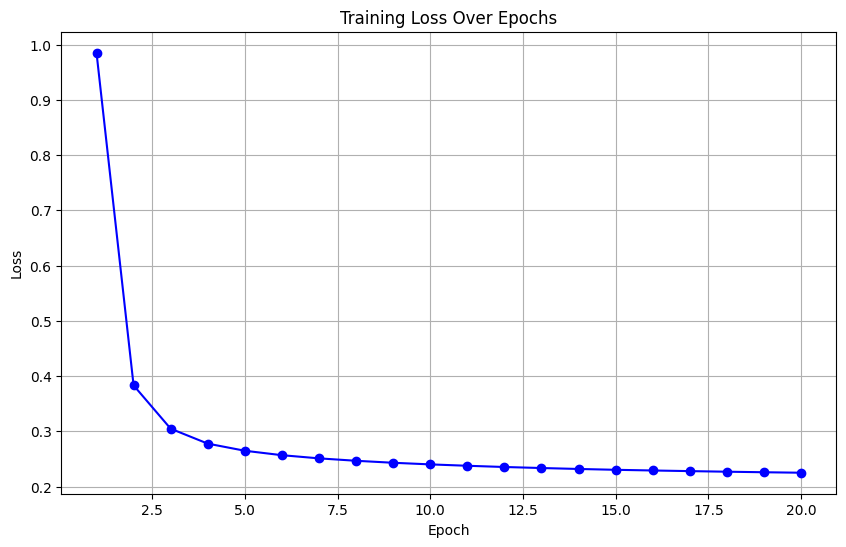

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the Skip-Gram model with negative sampling
class Word2Vec(nn.Module):
    def __init__(self, voc_size, embedding_size):
        super(Word2Vec, self).__init__()
        self.voc_size = voc_size
        self.embedding_size = embedding_size
        self.target_embeddings = nn.Embedding(voc_size, embedding_size)
        self.context_embeddings = nn.Embedding(voc_size, embedding_size)
        self.target_embeddings.weight.data.uniform_(-1, 1)
        self.context_embeddings.weight.data.uniform_(-1, 1)

    def forward(self, target, context):
        target_emb = self.target_embeddings(target)
        context_emb = self.context_embeddings(context)
        scores = torch.mul(target_emb, context_emb).sum(dim=1)
        return scores



# Define hyperparameters
embedding_size = 128
num_epochs = 20

# Create DataLoader
dataset = create_dataset(targets, contexts, labels, batch_size)

# Initialize the model, loss function, and optimizer
model = Word2Vec(voc_size, embedding_size)
model.train()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# List to store loss values
loss_values = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0
    for batch_targets, batch_contexts, batch_labels in dataset:
        optimizer.zero_grad()
        output = model(batch_targets, batch_contexts)
        loss = criterion(output, batch_labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataset)
    loss_values.append(avg_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

# Plot the loss values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()


The output indicates that the training process is working well. The model starts with a high loss, indicating poor initial performance, but improves significantly over 20 epochs, as shown by the decreasing loss values. The plot provides a clear visual representation of this improvement, with the training loss decreasing and stabilizing as the model converges. This suggests that the model is learning effectively from the data and that the training parameters are set appropriately.

## TASK 4
given the list of movies provided, build the embedding using the trained model and visualize the results. In particular, for each movie get the 5 more similar movies according to a similarity function you want. Then reduce the dimension of the embeddings produced to visualize these movies in a graph.

Movies similar to 'Matrix, The (1999)': ['Gladiator (2000)', 'Miracle on 34th Street (1947)', 'Crash (2004)', 'Enemy of the State (1998)', 'Dark Knight Rises, The (2012)']
Movies similar to 'Star Wars: Episode IV - A New Hope (1977)': ['Star Wars: Episode V - The Empire Strikes Back (1980)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'First Blood (Rambo: First Blood) (1982)', 'Jurassic Park (1993)', 'Fantasia (1940)']
Movies similar to 'Lion King, The (1994)': ['Dolores Claiborne (1995)', 'Casper (1995)', 'Beauty and the Beast (1991)', 'Sleepless in Seattle (1993)', 'Rush (2013)']
Movies similar to 'Terminator 2: Judgment Day (1991)': ['Star Wars: Episode VI - Return of the Jedi (1983)', 'Total Recall (1990)', 'Net, The (1995)', 'Cabin in the Woods, The (2012)', 'Aliens (1986)']
Movies similar to 'Godfather, The (1972)': ['Godfather: Part II, The (1974)', 'French Connection, The (1971)', 'Three Days of the Condor (3 Days of the Condor) (1975)', 'Christmas Story, A (1983)', 'O

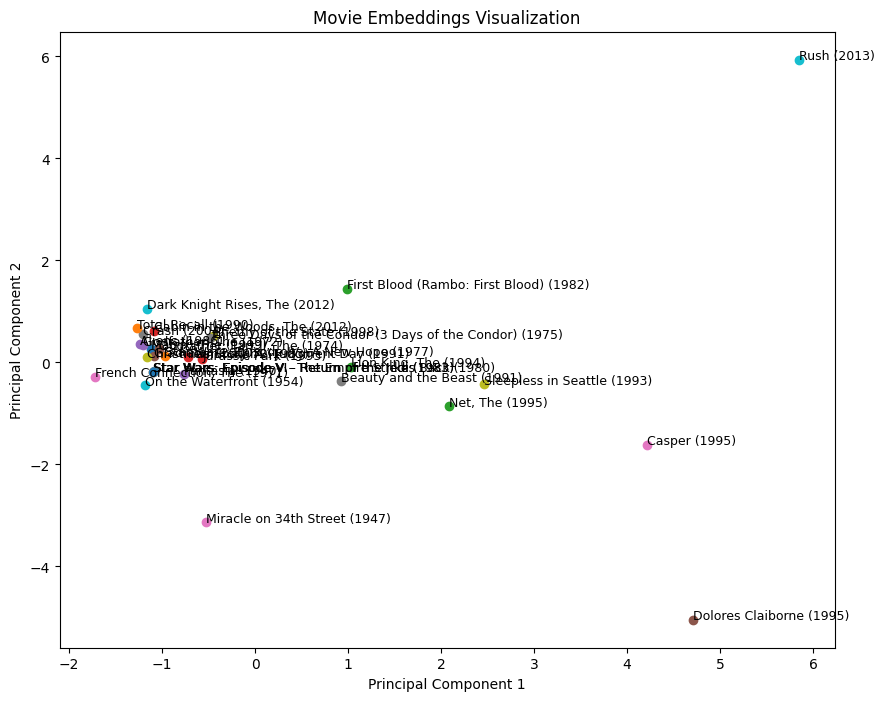

In [ ]:
# Extract embeddings from the model
target_embeddings = model.target_embeddings.weight.data.cpu().numpy()

# Function to get movie embeddings
def get_movie_embedding(movie_title):
    movie_id = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movie_id]
    return target_embeddings[token_id]

from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarities
def compute_similarities(embedding, embeddings):
    similarities = cosine_similarity([embedding], embeddings)[0]
    return similarities

# Function to find top N similar movies
def find_similar_movies(movie_title, top_n=5):
    movie_embedding = get_movie_embedding(movie_title)
    similarities = compute_similarities(movie_embedding, target_embeddings)
    similar_indices = np.argsort(similarities)[::-1][1:top_n + 1]
    similar_movies = [vocabulary[idx] for idx in similar_indices]
    similar_movie_titles = [get_movie_title_by_id(movie_id) for movie_id in similar_movies]
    return similar_movie_titles


# Query movies
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)"
]

# Find and print similar movies for each query movie
for movie in query_movies:
    similar_movies = find_similar_movies(movie)
    print(f"Movies similar to '{movie}': {similar_movies}")

# Visualization
from sklearn.decomposition import PCA

def reduce_dimensions(embeddings, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_embeddings = pca.fit_transform(embeddings)
    return reduced_embeddings

all_movie_titles = query_movies + [similar_movie for movie in query_movies for similar_movie in find_similar_movies(movie)]
all_movie_embeddings = [get_movie_embedding(movie) for movie in all_movie_titles]
reduced_embeddings = reduce_dimensions(all_movie_embeddings)

# Visualization
def plot_embeddings(movie_titles, embeddings):
    plt.figure(figsize=(10, 8))
    for i, (title, coord) in enumerate(zip(movie_titles, embeddings)):
        plt.scatter(coord[0], coord[1])
        plt.text(coord[0], coord[1], title, fontsize=9)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Movie Embeddings Visualization')
    plt.show()

plot_embeddings(all_movie_titles, reduced_embeddings)



# **List for query movies**

In [ ]:
# Define the query movies
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)"
]

# Function to get similar movies for a list of query movies
def print_similar_movies(query_movies, top_n=5):
    for movie in query_movies:
        similar_movies = find_similar_movies(movie, top_n=top_n)
        print(f"Movies similar to '{movie}':")
        for idx, similar_movie in enumerate(similar_movies, 1):
            print(f"{idx}. {similar_movie}")
        print("\n")

# Print similar movies
print_similar_movies(query_movies)

Movies similar to 'Matrix, The (1999)':
1. Gladiator (2000)
2. Miracle on 34th Street (1947)
3. Crash (2004)
4. Enemy of the State (1998)
5. Dark Knight Rises, The (2012)


Movies similar to 'Star Wars: Episode IV - A New Hope (1977)':
1. Star Wars: Episode V - The Empire Strikes Back (1980)
2. Star Wars: Episode VI - Return of the Jedi (1983)
3. First Blood (Rambo: First Blood) (1982)
4. Jurassic Park (1993)
5. Fantasia (1940)


Movies similar to 'Lion King, The (1994)':
1. Dolores Claiborne (1995)
2. Casper (1995)
3. Beauty and the Beast (1991)
4. Sleepless in Seattle (1993)
5. Rush (2013)


Movies similar to 'Terminator 2: Judgment Day (1991)':
1. Star Wars: Episode VI - Return of the Jedi (1983)
2. Total Recall (1990)
3. Net, The (1995)
4. Cabin in the Woods, The (2012)
5. Aliens (1986)


Movies similar to 'Godfather, The (1972)':
1. Godfather: Part II, The (1974)
2. French Connection, The (1971)
3. Three Days of the Condor (3 Days of the Condor) (1975)
4. Christmas Story, A (1983)

**Similar to Star Wars: Episode IV:** Star Wars: Episode V - The Empire Strikes Back (1980) and Star Wars: Episode VI - Return of the Jedi (1983) are direct sequels, making them natural recommendations. Also, First Blood (1982) and Jurassic Park (1993), while being action-packed like Star Wars, differ in setting and themes.

**Similar to Lion King:** Beauty and the Beast (1991) and Casper (1995) are fitting choices as they are family-friendly and involve themes of love and personal growth. Also, Total Recall (1990) and Aliens (1986) are excellent matches due to their science fiction and action elements, similar to "Terminator 2".

**Similar to Godfather:** Godfather: Part II, The (1974) is a direct sequel, making it a perfect match.
French Connection, The (1971) and On the Waterfront (1954) are strong matches due to their crime and drama themes.

**Similar to Matrix:** Gladiator (2000) and Dark Knight Rises, The (2012) are action-packed and epic movies, which share a similar intense and dramatic tone with "The Matrix".

**General Comments**
**Overall Accuracy: **The recommendations are generally accurate, especially for movies within the same franchise or those with similar genres and themes. However, there are some notable outliers that do not fit the expected genre or thematic elements of the query movies.

**Recommendation System:** The system effectively finds movies with overlapping audiences and thematic elements but occasionally includes movies with different tones or genres, suggesting areas for improvement in the algorithm.
Outliers: Movies like "Miracle on 34th Street" and "Christmas Story, A" indicate that while the system finds popular movies, it sometimes misses the genre-specific relevance. Fine-tuning the algorithm to consider more contextual or genre-specific attributes could improve recommendations.

# **Plotting for query movies**


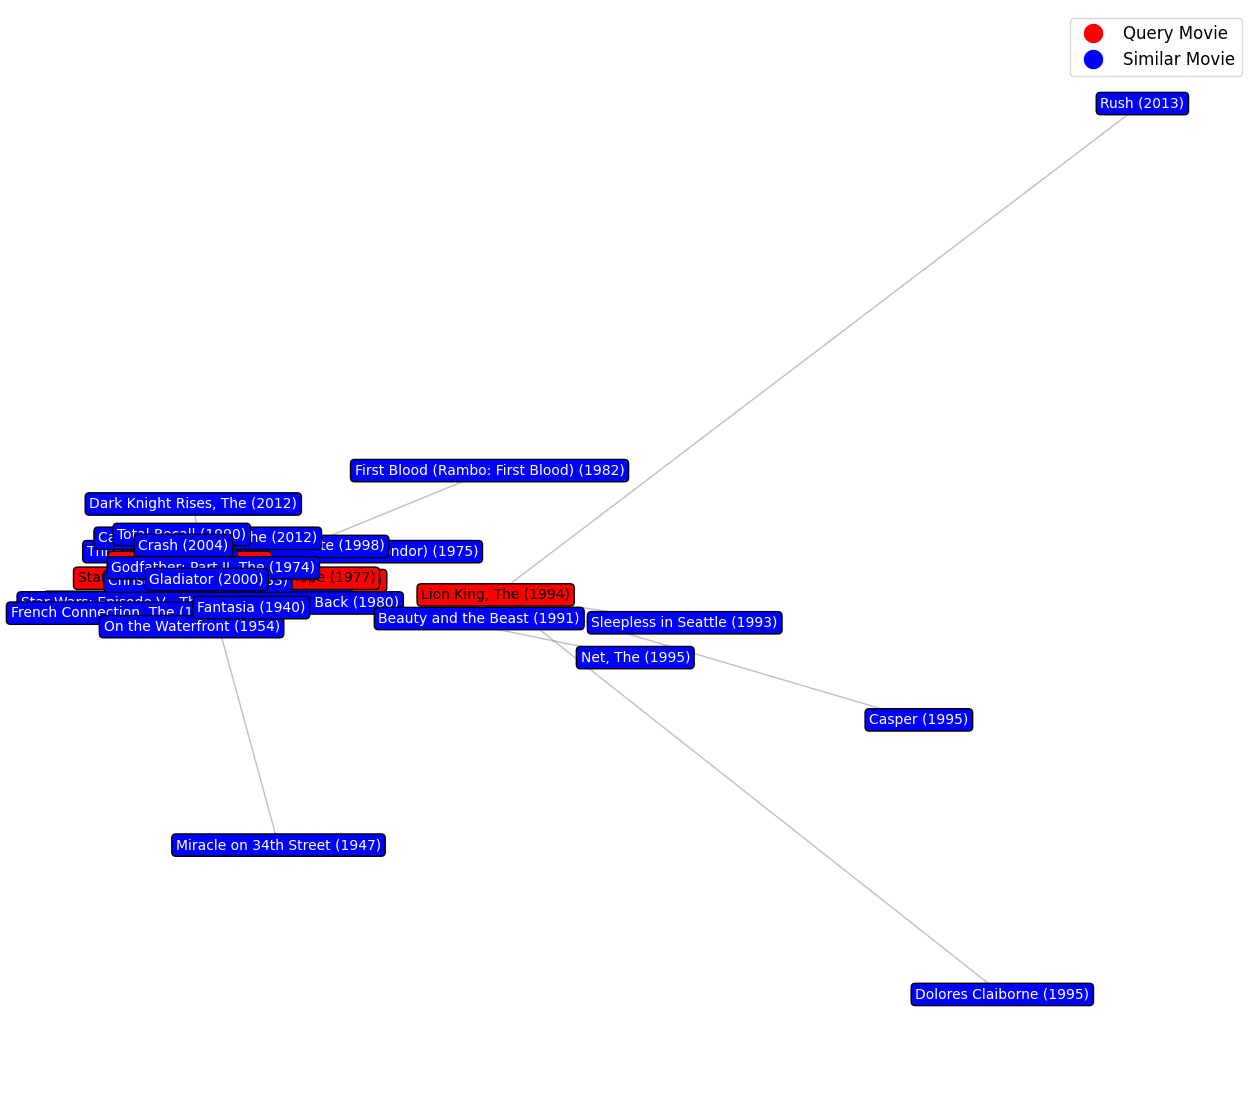

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA

# Function to get the movie ID by title
def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

# Function to get the movie title by ID
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

# Function to get movie embeddings
def get_movie_embedding(movie_title):
    movie_id = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movie_id]
    return target_embeddings[token_id]

# Define the movies to visualize
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)"
]

# Assuming find_similar_movies is defined and implemented
similar_movies = {}
for movie in query_movies:
    similar_movies[movie] = find_similar_movies(movie)

# Create the graph
G = nx.Graph()

# Add nodes for the query movies and their similar movies
all_movies = set(query_movies)
for movie_list in similar_movies.values():
    all_movies.update(movie_list)

# Add nodes with positions
for movie in all_movies:
    G.add_node(movie, embedding=get_movie_embedding(movie))

# Add edges between query movies and their similar movies
for movie, similar_list in similar_movies.items():
    for similar_movie in similar_list:
        G.add_edge(movie, similar_movie)

# Use PCA to reduce dimensions for visualization
embeddings = [G.nodes[node]['embedding'] for node in G.nodes]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a dictionary for positions
positions = {movie: reduced_embeddings[i] for i, movie in enumerate(G.nodes)}

# Define node colors based on criteria (e.g., query or similar movie)
node_colors = ['red' if movie in query_movies else 'blue' for movie in G.nodes]

# Plot the graph with better node labeling
plt.figure(figsize=(16, 14))
nx.draw_networkx_edges(G, pos=positions, edge_color='gray', alpha=0.5)

# Draw nodes with labels fitting inside nodes
for node, (x, y) in positions.items():
    text_color = 'black' if node_colors[list(G.nodes).index(node)] == 'red' else 'white'
    plt.text(x, y, node, fontsize=10, ha='center', va='center',
             bbox=dict(facecolor=node_colors[list(G.nodes).index(node)], edgecolor='black', boxstyle='round,pad=0.3'), color=text_color)

# Add a legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Query Movie', markersize=15, markerfacecolor='red'),
    Line2D([0], [0], marker='o', color='w', label='Similar Movie', markersize=15, markerfacecolor='blue')
]
plt.legend(handles=legend_elements, loc='best', fontsize=12)

plt.axis('off')  # Turn off the axis
plt.show()

Since we can't read this graph clearly:

In the first plot, the import statement for Line2D is placed just before creating the legend, whereas in the plot below, it's at the top along with other import statements. This is a minor organizational change for better readability.

# **Here is a better looking graph**


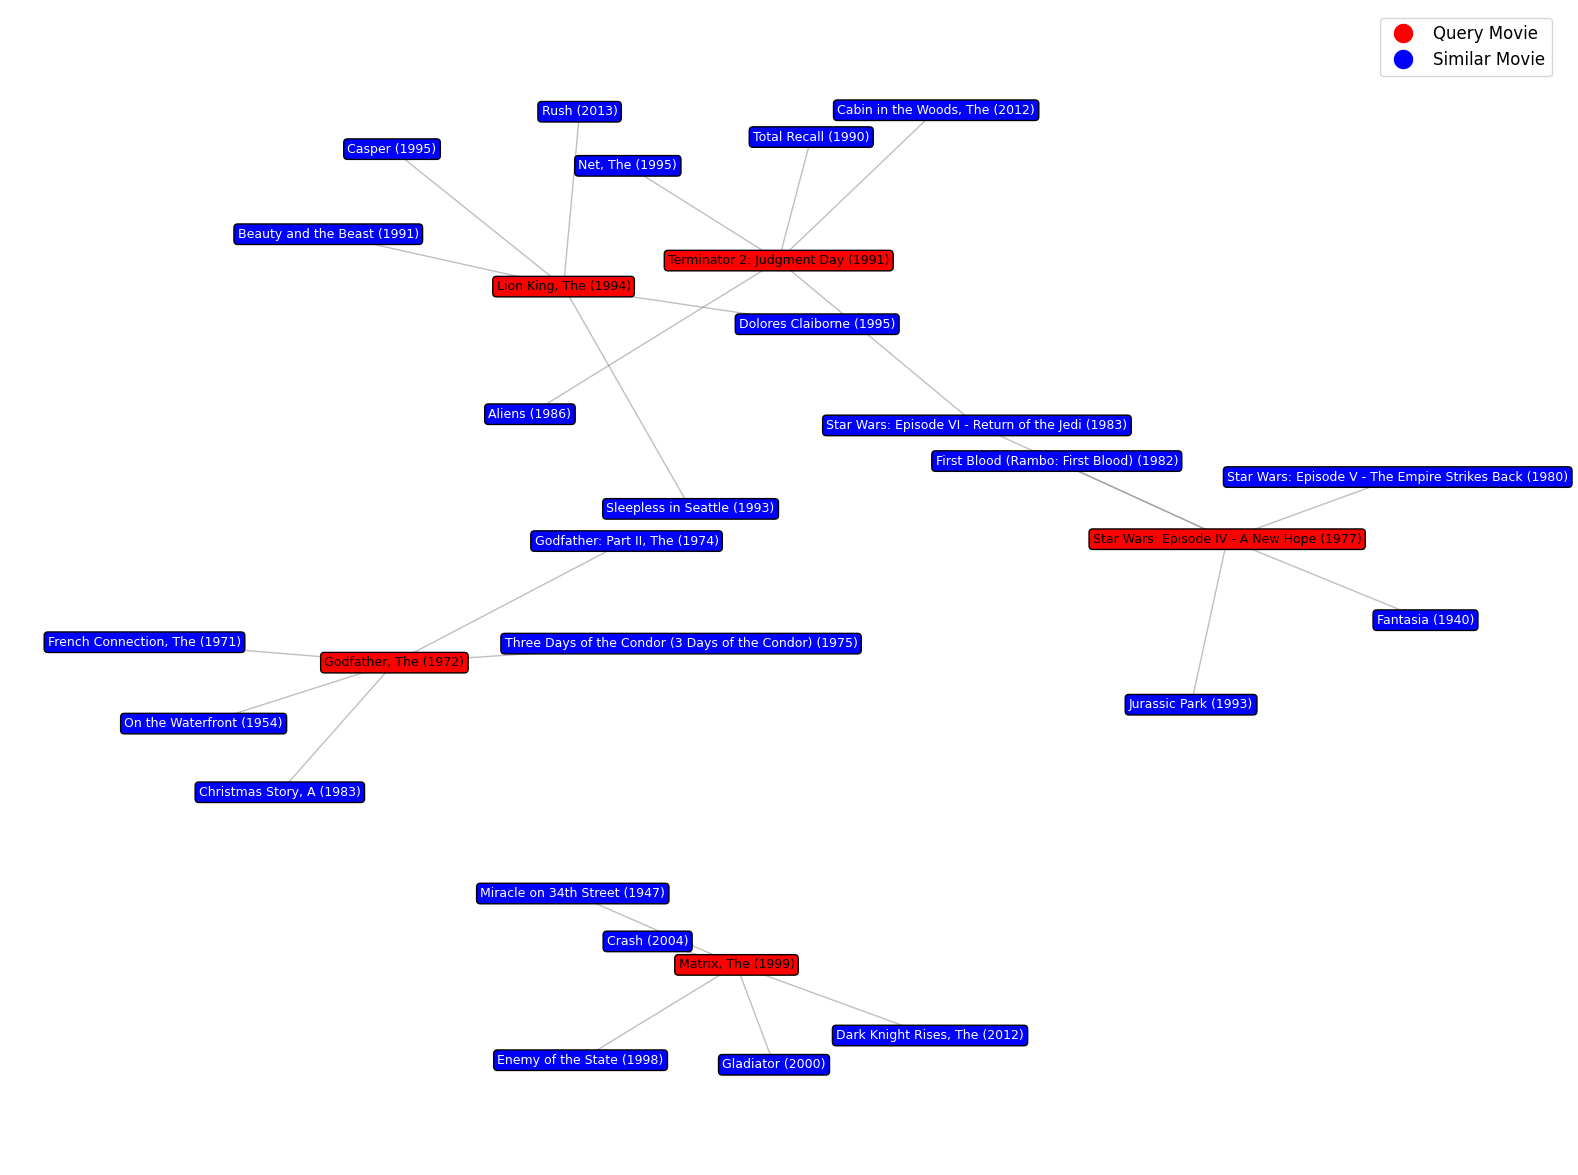

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.decomposition import PCA
from matplotlib.lines import Line2D

# Function to get the movie ID by title
def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]

# Function to get the movie title by ID
def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]

# Function to get movie embeddings
def get_movie_embedding(movie_title):
    movie_id = get_movie_id_by_title(movie_title)
    token_id = vocabulary_lookup[movie_id]
    return target_embeddings[token_id]

# Define the movies to visualize
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)"
]

# Assuming find_similar_movies is defined and implemented
similar_movies = {}
for movie in query_movies:
    similar_movies[movie] = find_similar_movies(movie)

# Create the graph
G = nx.Graph()

# Add nodes for the query movies and their similar movies
all_movies = set(query_movies)
for movie_list in similar_movies.values():
    all_movies.update(movie_list)

# Add nodes with positions
for movie in all_movies:
    G.add_node(movie, embedding=get_movie_embedding(movie))

# Add edges between query movies and their similar movies
for movie, similar_list in similar_movies.items():
    for similar_movie in similar_list:
        G.add_edge(movie, similar_movie)

# Use PCA to reduce dimensions for visualization
embeddings = [G.nodes[node]['embedding'] for node in G.nodes]
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Create a dictionary for positions
positions = {movie: reduced_embeddings[i] for i, movie in enumerate(G.nodes)}

# Define node colors based on criteria (e.g., query or similar movie)
node_colors = ['red' if movie in query_movies else 'blue' for movie in G.nodes]

# Adjust positions to avoid overlap
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Plot the graph with better node labeling
plt.figure(figsize=(20, 15))
nx.draw_networkx_edges(G, pos=pos, edge_color='gray', alpha=0.5)

# Draw nodes with labels fitting inside nodes
for node, (x, y) in pos.items():
    text_color = 'black' if node_colors[list(G.nodes).index(node)] == 'red' else 'white'
    plt.text(x, y, node, fontsize=9, ha='center', va='center',
             bbox=dict(facecolor=node_colors[list(G.nodes).index(node)], edgecolor='black', boxstyle='round,pad=0.3'), color=text_color)

# Add a legend
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Query Movie', markersize=15, markerfacecolor='red'),
    Line2D([0], [0], marker='o', color='w', label='Similar Movie', markersize=15, markerfacecolor='blue')
]
plt.legend(handles=legend_elements, loc='best', fontsize=12)

plt.axis('off')  # Turn off the axis
plt.show()
